# Predicting Loan Defaults

### Names:
Hayden Strikwerda, Bryce Kastner, and Hannah George

### Project Purpose

Our project is to predict loan defaults using machine learning. Through this project we hope to gain a clearer understanding of what factors most strongly influence whether a loan is approved or not and to use this information to create a machine learning algorithm which predicts whether a loan would be approved or not.

In order to do so we first found our dataset (located at http://weka.8497.n7.nabble.com/file/n23121/credit_fruad.arff) and cleaned it, turning each of the columns into numerical data. 

## Imports

In [3]:
from scipy.io import arff
import pandas as pd
import numpy as np

from sklearn import tree, svm, metrics
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Loading the Data

In [4]:
data = pd.DataFrame(arff.loadarff('german_credit_fruad.arff.txt')[0])

## Cleaning the Data

The following code is for cleaning the data. First we deleted some of the columns that felt unnessary, and rename others. Then we go through and change the type of the data from bytes to string. Then, in order to make the data easier to work with, we changed the data type from strings to integers. We provide a key for the numerical values at the top of the code.  At the end, we saved our dataframe with the cleaned data into a csv file to save time. 

In [5]:
del data['employment']
del data['other_parties']
del data['property_magnitude']
del data['other_payment_plans']
del data['own_telephone']
del data['location']
del data['num_dependents']
del data['residence_since']

data.rename(columns={'over_draft':'checking_balance', 
                     'Average_Credit_Balance': 'savings_balance', 
                     'cc_age':'age'}, 
            inplace=True)

Here is the key for reference:

'''
Attributes  age, credit_usage, current_balance, and existing_credits do not require a value key.

 Value Key for attribute checking_balance
    
    0     Represents: None        
    1     Represents: Less than 0                          
    2     Represents: In between 0 and 200                      
    3     Represents: Greater than 200  
    
 Value Key for attribute class
    0     Represents: Denied                                          
    1     Represents: Approved  

 Value Key for attribute credit_history
    0     Represents: None          
    1     Represents: Bad                                  
    2     Represents: Fair                        
    3     Represents: Good              
    4     Represents: Great
    
 Value Key for attribute foreign_worker
    0     Represents: No                                            
    1     Represents: Yes  
    
 Value Key for attribute gender
    0     Represents: Male
    1     Represents: Female
    
 Value Key for attribute housing
    0     Represents: Rent                                         
    1     Represents: Own                                           
    2     Represents: For Free 
    
Value Key for attribute job
    0     Represents: Unemployed       
    1     Represents: Unskilled             
    2     Represents: Skilled                                    
    3     Represents: Highly Skilled    
    
 Value Key for attribute purpose
    0     Represents: New Car                                  
    1     Represents: Used Car                                
    2     Represents: Furniture/Equipment            
    3     Represents: Radio/TV                                  
    4     Represents: Domestic Appliance            
    5     Represents: Repairs                                    
    6     Represents: Education                               
    7     Represents: Vacation                                  
    8     Represents: Retraining                              
    9     Represents: Business                                  
    10    Represents: Other                                        

 Value Key for attribute savings_balance
    0     Represents: None                            
    1     Represents: Less than 100                              
    2     Represents: Inbetween 100 and 500                      
    3     Represents: Inbetween 500 and 1000                               
    4     Represents: Greater than 1000                          

                       
'''             

This next bit of code is for changing the type of some of the columns from byte to string.

In [6]:
for column in data.columns:
    i = 0
    for item in data[column]:
        if isinstance(item, bytes) == True:
                fixed = item.decode("utf-8")
                fixed = fixed.replace("'","")
                data.loc[i, column] = str(fixed)
                item = str(fixed)
        i += 1

Next, we want to change the data into a more workable type so we convert some of the columns from a string to an integer. 

In [7]:
gender = []

for column in data.columns:
    
    relabeled = []
    
    for item in data[column]:
        if column == 'checking_balance':
            if item == 'no checking':
                relabeled.append(0)
            elif item == '<0':
                relabeled.append(1)
            elif item == '0<=X<200':
                relabeled.append(2)
            elif item == '>=200':
                relabeled.append(3)
            else:
                relabeled.append('ERROR')
        elif column == 'credit_history':
            if item == 'no credits/all paid':
                relabeled.append(0)
            elif item == 'all paid':
                relabeled.append(1)
            elif item == 'existing paid':
                relabeled.append(2)
            elif item == 'delayed previously':
                relabeled.append(3)
            elif item == 'critical/other existing credit':
                relabeled.append(4)
            else:
                relabeled.append('ERROR')
        elif column == 'purpose':
            if item == 'new car':
                relabeled.append(0)
            elif item == 'used car':
                relabeled.append(1)
            elif item == 'furniture/equipment':
                relabeled.append(2)
            elif item == 'radio/tv':
                relabeled.append(3)
            elif item == 'domestic appliance':
                relabeled.append(4)
            elif item == 'repairs':
                relabeled.append(5)
            elif item == 'education':
                relabeled.append(6)
            elif item == 'vacation':
                relabeled.append(7)
            elif item == 'retraining':
                relabeled.append(8)
            elif item == 'business':
                relabeled.append(9)
            elif item == 'other':
                relabeled.append(10)
            else:
                relabeled.append('ERROR')
        elif column == 'savings_balance':
            if item == 'no known savings':
                relabeled.append(0)
            elif item == '<100':
                relabeled.append(1)
            elif item == '100<=X<500':
                relabeled.append(2)
            elif item == '500<=X<1000':
                relabeled.append(3)
            elif item == '>=1000':
                relabeled.append(4)
        elif column == 'personal_status':
            if item == 'male single':
                relabeled.append(0)
                gender.append(0)
            elif item == 'male mar/wid':
                relabeled.append(1)
                gender.append(0)
            elif item == 'male div/sep':
                relabeled.append(2)
                gender.append(0)
            elif item == 'female single':
                relabeled.append(3)
                gender.append(1)
            elif item == 'female div/dep/mar':
                relabeled.append(4)
                gender.append(1)
        elif column == 'housing':
            if item == 'for free':
                relabeled.append(0)
            elif item == 'rent':
                relabeled.append(1)
            elif item == 'own':
                relabeled.append(2)
        elif column == 'job':
            if item == 'unemp/unskilled non res':
                relabeled.append(0)
            elif item == 'unskilled resident':
                relabeled.append(1)
            elif item == 'skilled':
                relabeled.append(2)
            elif item == 'high qualif/self emp/mgmt':
                relabeled.append(3)
        elif column == 'foreign_worker':
            if item == 'no':
                relabeled.append(0)
            elif item == 'yes':
                relabeled.append(1)
        elif column == 'class':
            if item == 'bad':
                relabeled.append(0)
            elif item == 'good':
                relabeled.append(1)
            
    if len(relabeled) != 0:
        data[column] = relabeled

data['gender'] = gender
del data['personal_status']

Now we save the data into a .csv file.

In [8]:
data.to_csv('cleanedData.csv')

## Loading the Data From the New .csv File

In [9]:
data = pd.read_csv('cleanedData.csv')
data = data.drop('Unnamed: 0', axis=1)
data = data.reindex(sorted(data.columns), axis=1)
data.head()

,age,checking_balance,class,credit_history,credit_usage,current_balance,existing_credits,foreign_worker,gender,housing,job,purpose,savings_balance
0,67.0,1,1,4,6.0,1169.0,2.0,1,0,2,2,3,0
1,22.0,2,0,2,48.0,5951.0,1.0,1,1,2,2,3,1
2,49.0,0,1,4,12.0,2096.0,1.0,1,0,2,1,6,1
3,45.0,1,1,2,42.0,7882.0,1.0,1,0,0,2,2,1
4,53.0,1,0,3,24.0,4870.0,2.0,1,0,0,2,0,1


## Visualizing the Data

This next code is here to understand the relationships between the variables.

In [10]:
corr = data.corr()
corr

,age,checking_balance,class,credit_history,credit_usage,current_balance,existing_credits,foreign_worker,gender,housing,job,purpose,savings_balance
age,1.000000,-0.049058,0.091127,0.147086,-0.036136,0.032716,0.149254,0.006151,-0.161694,-0.112051,0.015673,0.001312,-0.017997
checking_balance,-0.049058,1.000000,-0.197788,-0.157931,0.035050,0.024561,-0.093081,0.000205,0.021903,-0.048984,-0.054255,0.053421,-0.005614
class,0.091127,-0.197788,1.000000,0.228785,-0.214927,-0.154739,0.045732,-0.082079,-0.075493,0.127789,-0.032735,-0.017979,0.033871
credit_history,0.147086,-0.157931,0.228785,1.000000,-0.077186,-0.059905,0.437066,-0.013873,-0.071802,0.077066,0.010350,-0.090336,0.005209
credit_usage,-0.036136,0.035050,-0.214927,-0.077186,1.000000,0.624984,-0.011284,0.138196,-0.081432,-0.137434,0.210910,0.147492,-0.064526
current_balance,0.032716,0.024561,-0.154739,-0.059905,0.624984,1.000000,0.020795,0.050050,-0.093482,-0.171585,0.285385,0.068474,-0.107538
existing_credits,0.149254,-0.093081,0.045732,0.437066,-0.011284,0.020795,1.000000,0.009717,-0.094260,0.022506,-0.026321,0.054935,-0.004176
foreign_worker,0.006151,0.000205,-0.082079,-0.013873,0.138196,0.050050,0.009717,1.000000,0.051202,-0.044100,0.100944,0.099725,-0.005318
gender,-0.161694,0.021903,-0.075493,-0.071802,-0.081432,-0.093482,-0.094260,0.051202,1.000000,-0.033818,-0.070298,-0.039160,0.029310
housing,-0.112051,-0.048984,0.127789,0.077066,-0.137434,-0.171585,0.022506,-0.044100,-0.033818,1.000000,-0.101939,0.050836,0.033827


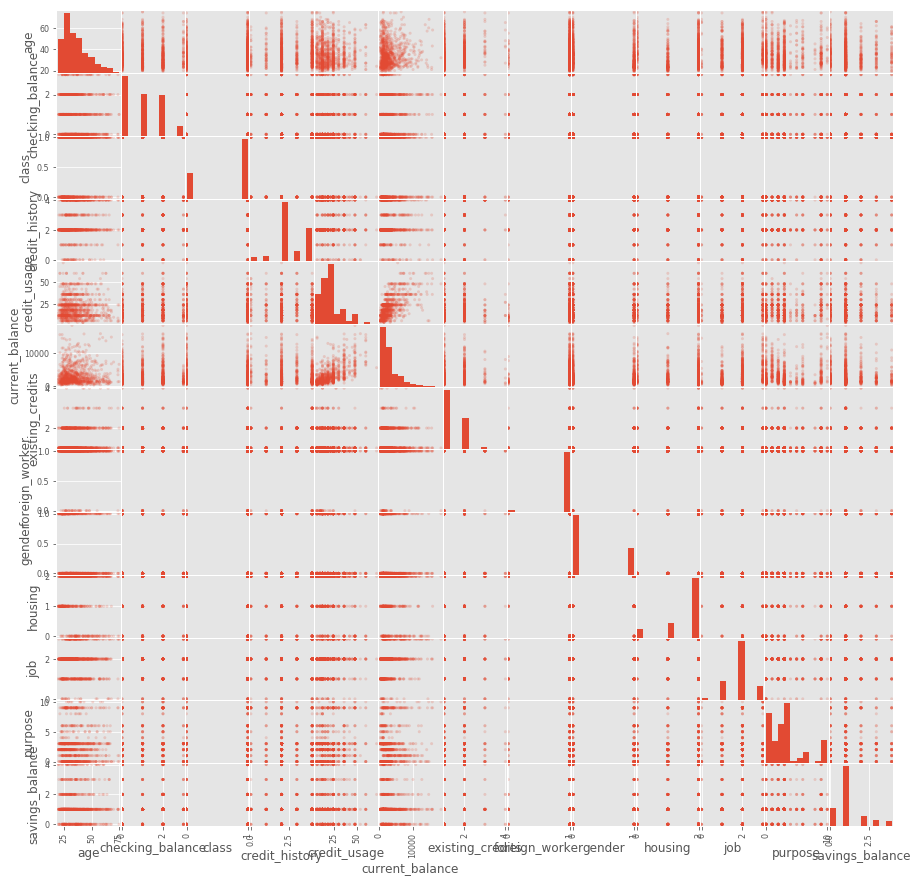

In [11]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = 0.2, figsize=(15, 15))
print('')

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

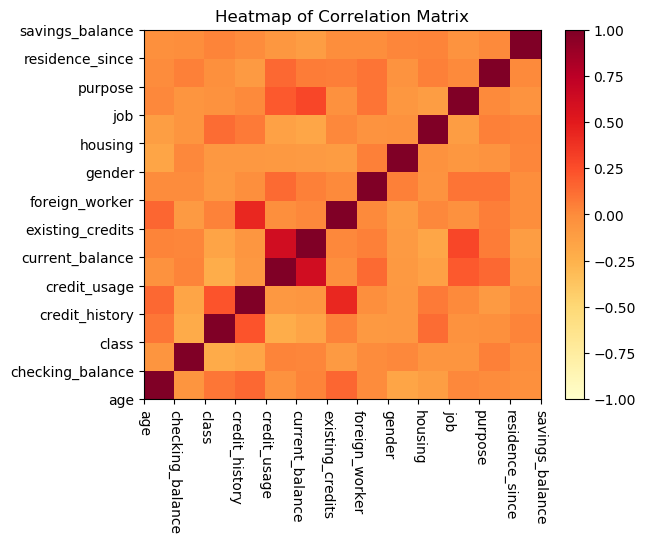

In [12]:
# Computing the correlation matrix
correlation = data.corr()

# Calculate and visualize correlations as matrix
plt.style.use('default')
heatmap = plt.pcolor(correlation, cmap=plt.cm.YlOrRd, vmin = -1, vmax = 1)

# Plot the legend on the side
plt.colorbar(heatmap)
plt.xticks(np.arange(14), ['age', 'checking_balance','class', 'credit_history',
           'credit_usage', 'current_balance', 'existing_credits',
           'foreign_worker', 'gender', 'housing', 'job',  
            'purpose', 'residence_since', 'savings_balance'], 
        rotation = -90)
plt.yticks(np.arange(14), ['age', 'checking_balance','class', 'credit_history',
           'credit_usage', 'current_balance', 'existing_credits',
           'foreign_worker', 'gender', 'housing', 'job',  
            'purpose', 'residence_since', 'savings_balance'])

plt.title("Heatmap of Correlation Matrix")

In [13]:
# Skewness. comparing to normal dist. pos values (>0) indicates more weight in the left tail of the distribution.
skew = data.skew()
skew

age                 1.020739
checking_balance    0.430530
class              -0.874183
credit_history     -0.011886
credit_usage        1.094184
current_balance     1.949628
existing_credits    1.272576
foreign_worker     -4.913027
gender              0.822868
housing            -1.443158
job                -0.374295
purpose             1.178887
savings_balance     1.310342
dtype: float64

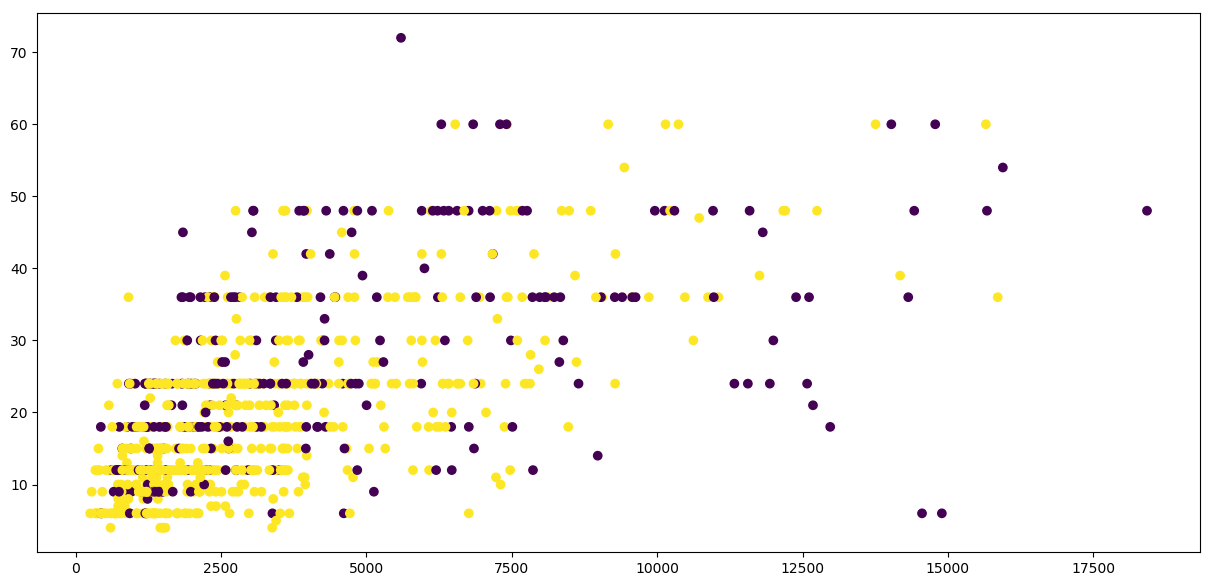

In [14]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(x = data['current_balance'], y = data['credit_usage'],c = data['class'])
plt.show()

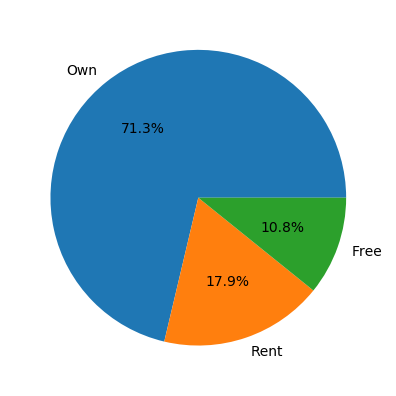

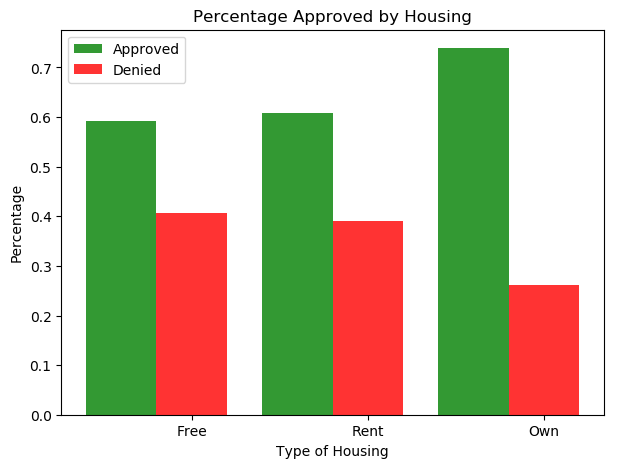

In [15]:
housing_value_counts = data['housing'].value_counts()

plt.pie(housing_value_counts, labels = ['Own', 'Rent', 'Free'], 
        radius = 1, autopct='%1.1f%%')

rent = data[data['housing'] == 1]
own = data[data['housing'] == 2]
free = data[data['housing'] == 0]

rent_percentages = rent['class'].value_counts() / len(rent)
own_percentages = own['class'].value_counts() / len(own)
free_percentages = free['class'].value_counts() / len(free)

housing_approved = [free_percentages[1],rent_percentages[1], own_percentages[1]]
housing_denied = [free_percentages[0], rent_percentages[0], own_percentages[0]]

# data to plot
n_groups = 3
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, housing_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, housing_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Type of Housing')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Housing')
plt.xticks(index + bar_width, ('Free','Rent','Own'))
plt.legend()

plt.show()


print('')

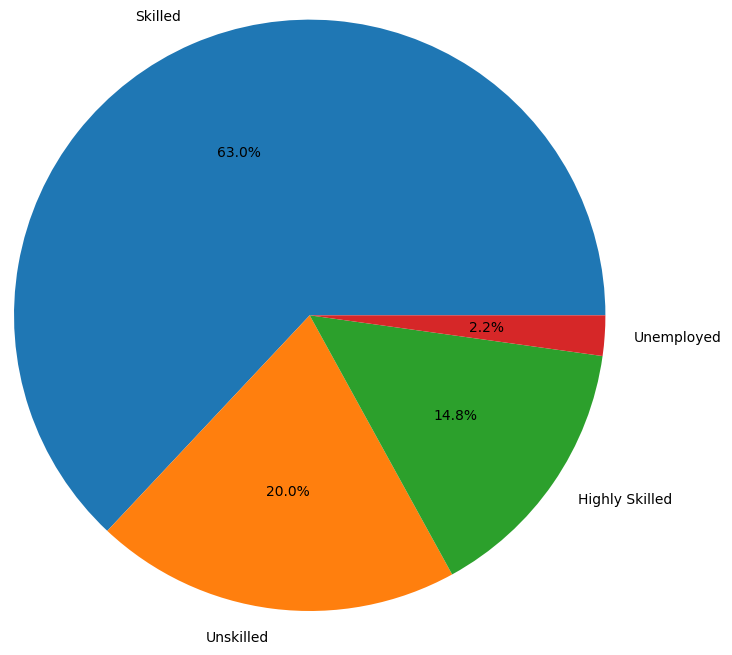

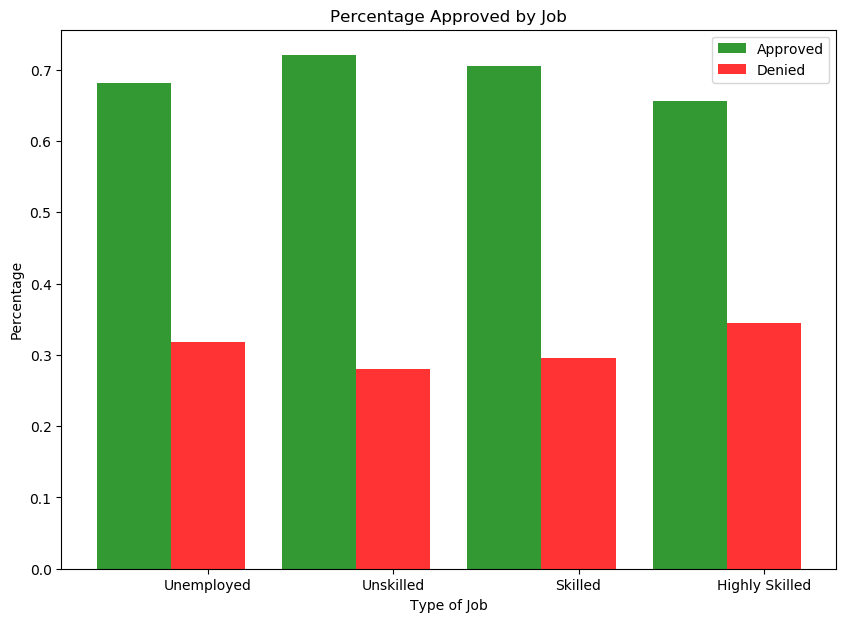

In [16]:
job_value_counts = data['job'].value_counts()

plt.pie(job_value_counts, labels = ['Skilled', 'Unskilled', 'Highly Skilled', 'Unemployed'],  
        radius = 2, autopct='%1.1f%%')


unemployed = data[data['job'] == 0]
unskilled = data[data['job'] == 1]
skilled = data[data['job'] == 2]
highly_skilled = data[data['job'] == 3]

unemployed_percentages = unemployed['class'].value_counts() / len(unemployed)
unskilled_percentages = unskilled['class'].value_counts() / len(unskilled)
skilled_percentages = skilled['class'].value_counts() / len(skilled)
highly_skilled_percentages = highly_skilled['class'].value_counts() / len(highly_skilled)

job_approved = [unemployed_percentages[1], unskilled_percentages[1], skilled_percentages[1], highly_skilled_percentages[1]]
job_denied = [unemployed_percentages[0], unskilled_percentages[0], skilled_percentages[0], highly_skilled_percentages[0]]

# data to plot
n_groups = 4
 
# create plot
fig, ax = plt.subplots(figsize=(10,7))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, job_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, job_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Type of Job')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Job')
plt.xticks(index + bar_width, ('Unemployed','Unskilled', 'Skilled','Highly Skilled'))
plt.legend()

plt.show()

print('')

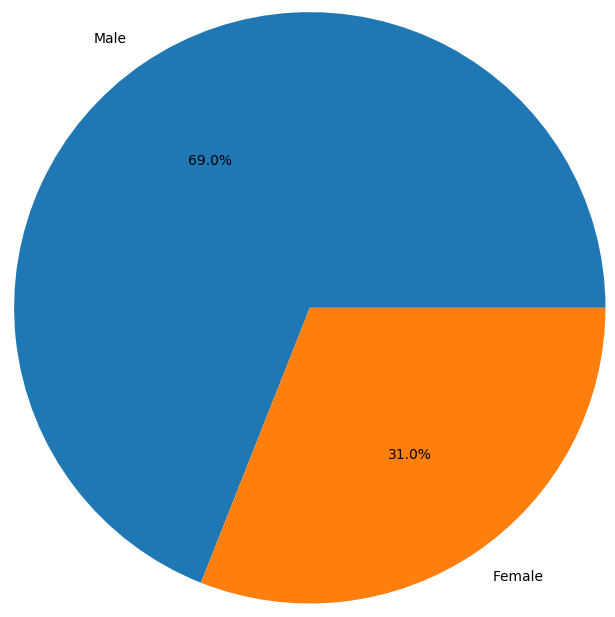

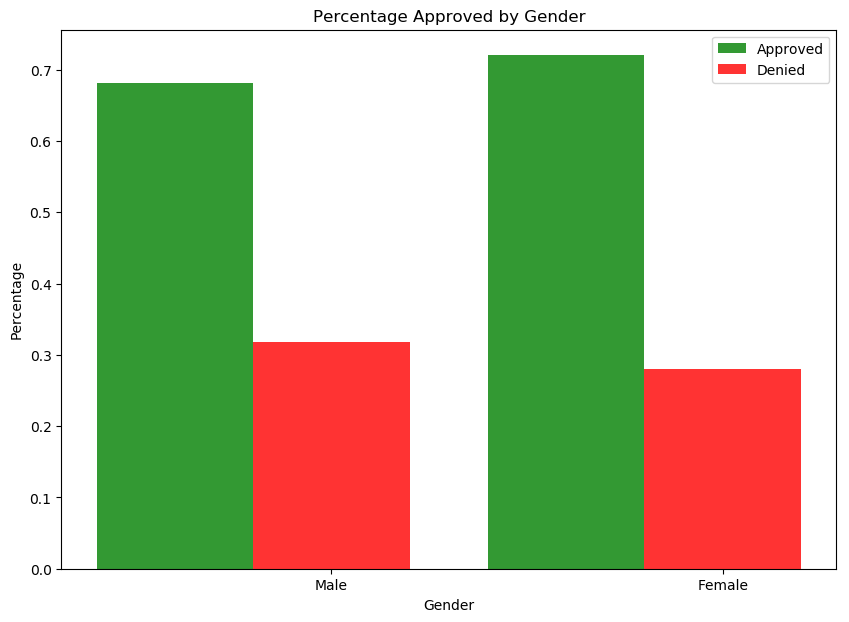

In [17]:
gender_value_counts = data['gender'].value_counts()

plt.pie(gender_value_counts, labels = ['Male', 'Female'],  
        radius = 2, autopct='%1.1f%%')

male = data[data['job'] == 0]
female = data[data['job'] == 1]

male_percentages = male['class'].value_counts() / len(male)
female_percentages = female['class'].value_counts() / len(female)

gender_approved = [male_percentages[1], female_percentages[1]]
gender_denied = [male_percentages[0], female_percentages[0]]

# data to plot
n_groups = 2
 
# create plot
fig, ax = plt.subplots(figsize=(10,7))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, gender_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, gender_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Gender')
plt.xticks(index + bar_width, ('Male','Female'))
plt.legend()

plt.show()
print('')

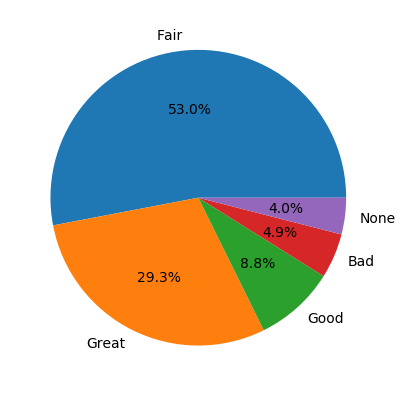

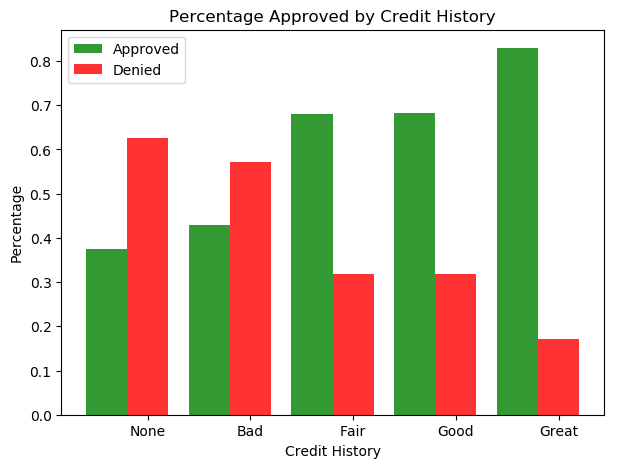

In [18]:
credhis_value_counts = data['credit_history'].value_counts()

plt.pie(credhis_value_counts, labels = ['Fair', 'Great', 'Good', 'Bad', 'None'],  
        radius = 1, autopct='%1.1f%%')

none = data[data['credit_history'] == 0]
bad = data[data['credit_history'] == 1]
fair = data[data['credit_history'] == 2]
good = data[data['credit_history'] == 3]
great = data[data['credit_history'] == 4]

none_percentages = none['class'].value_counts() / len(none)
bad_percentages = bad['class'].value_counts() / len(bad)
fair_percentages = fair['class'].value_counts() / len(fair)
good_percentages = good['class'].value_counts() / len(good)
great_percentages = great['class'].value_counts() / len(great)

credhis_approved = [none_percentages[1], bad_percentages[1], fair_percentages[1], 
                   good_percentages[1], great_percentages[1]]
credhis_denied = [none_percentages[0], bad_percentages[0], fair_percentages[0], 
                 good_percentages[0], great_percentages[0]]

# data to plot
n_groups = 5
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, credhis_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, credhis_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Credit History')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Credit History')
plt.xticks(index + bar_width, ('None', 'Bad','Fair', 'Good', 'Great'))
plt.legend()

plt.show()
print('')

1    603
0    183
2    103
3     63
4     48
Name: savings_balance, dtype: int64


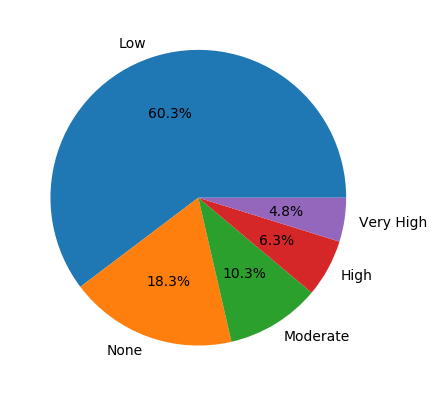

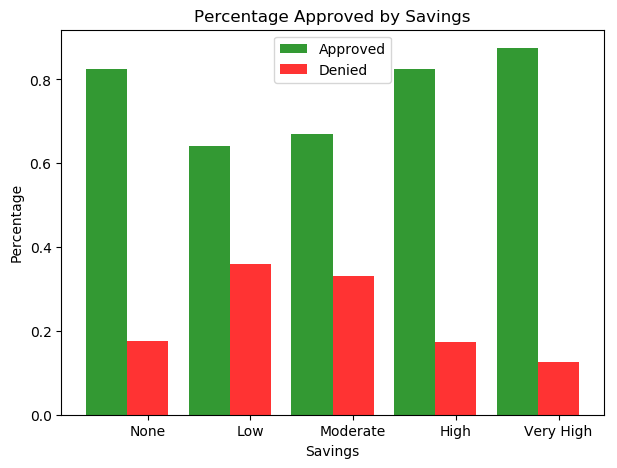

In [19]:
savings_value_counts = data['savings_balance'].value_counts()

plt.pie(savings_value_counts, labels = [ 'Low','None', 'Moderate', 'High','Very High'],  
        radius = 1, autopct='%1.1f%%')

print(savings_value_counts)

none = data[data['savings_balance'] == 0]
low = data[data['savings_balance'] == 1]
moderate = data[data['savings_balance'] == 2]
high = data[data['savings_balance'] == 3]
very_high = data[data['savings_balance'] == 4]

none_percentages = none['class'].value_counts() / len(none)
low_percentages = low['class'].value_counts() / len(low)
moderate_percentages = moderate['class'].value_counts() / len(moderate)
high_percentages = high['class'].value_counts() / len(high)
very_high_percentages = very_high['class'].value_counts() / len(very_high)

savings_approved = [none_percentages[1], low_percentages[1], moderate_percentages[1], 
                   high_percentages[1], very_high_percentages[1]]
savings_denied = [none_percentages[0], low_percentages[0], moderate_percentages[0], 
                 high_percentages[0], very_high_percentages[0]]

# data to plot
n_groups = 5
 
# create plot
fig, ax = plt.subplots(figsize=(7,5))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8
 
rects1 = plt.bar(index, savings_approved, bar_width,
alpha=opacity,
color='g',
label='Approved')
 
rects2 = plt.bar(index + bar_width, savings_denied, bar_width,
alpha=opacity,
color='r',
label='Denied')
 
plt.xlabel('Savings')
plt.ylabel('Percentage')
plt.title('Percentage Approved by Savings')
plt.xticks(index + bar_width, ('None', 'Low','Moderate', 'High', 'Very High'))
plt.legend()

plt.show()
print('')

## Creating the Machine Learning Algorithm

### Scaling the data.

In [20]:
scaler = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()
# scaling age
scaled_age = scaler.fit_transform(data[['age']])
flat_list1 = [item for sublist in scaled_age.tolist() for item in sublist]
scaled_age = pd.Series(flat_list1)

In [21]:
# scaled credit_usage.
scaled_cu = scaler2.fit_transform(data[['credit_usage']])
flat_list2 = [item for sublist in scaled_cu.tolist() for item in sublist]
scaled_cu = pd.Series(flat_list2)

In [22]:
# scaled current_balance.
scaled_cb = scaler3.fit_transform(data[['current_balance']])
flat_list3 = [item for sublist in scaled_cb.tolist() for item in sublist]
scaled_cb = pd.Series(flat_list3)

In [23]:
# scaled existig_credits
scaled_ec = scaler4.fit_transform(data[['existing_credits']])
flat_list4 = [item for sublist in scaled_ec.tolist() for item in sublist]
scaled_ec = pd.Series(flat_list4)

In [24]:
# concatenating newly created columns with original data
data1 = pd.concat([data, scaled_ec.rename('scaled_existing_credits'), scaled_cb.rename('scaled_current_balance'), scaled_cu.rename('scaled_credit_usage') ,scaled_age.rename('scaled_age')], axis=1)
data2 = pd.concat([data, scaled_ec.rename('scaled_existing_credits'), scaled_cb.rename('scaled_current_balance'), scaled_cu.rename('scaled_credit_usage') ,scaled_age.rename('scaled_age')], axis=1)
data1.head()

,age,checking_balance,class,credit_history,credit_usage,current_balance,existing_credits,foreign_worker,gender,housing,job,purpose,savings_balance,scaled_existing_credits,scaled_current_balance,scaled_credit_usage,scaled_age
0,67.0,1,1,4,6.0,1169.0,2.0,1,0,2,2,3,0,1.027079,-0.745131,-1.236478,2.766456
1,22.0,2,0,2,48.0,5951.0,1.0,1,1,2,2,3,1,-0.704926,0.949817,2.248194,-1.191404
2,49.0,0,1,4,12.0,2096.0,1.0,1,0,2,1,6,1,-0.704926,-0.416562,-0.738668,1.183312
3,45.0,1,1,2,42.0,7882.0,1.0,1,0,0,2,2,1,-0.704926,1.634247,1.750384,0.831502
4,53.0,1,0,3,24.0,4870.0,2.0,1,0,0,2,0,1,1.027079,0.566664,0.256953,1.535122


In [25]:
# Drop Old Entries for scaled columns.
data1.drop(['age', 'credit_usage', 'current_balance', 'existing_credits'], axis=1, inplace=True)
data1.head()

,checking_balance,class,credit_history,foreign_worker,gender,housing,job,purpose,savings_balance,scaled_existing_credits,scaled_current_balance,scaled_credit_usage,scaled_age
0,1,1,4,1,0,2,2,3,0,1.027079,-0.745131,-1.236478,2.766456
1,2,0,2,1,1,2,2,3,1,-0.704926,0.949817,2.248194,-1.191404
2,0,1,4,1,0,2,1,6,1,-0.704926,-0.416562,-0.738668,1.183312
3,1,1,2,1,0,0,2,2,1,-0.704926,1.634247,1.750384,0.831502
4,1,0,3,1,0,0,2,0,1,1.027079,0.566664,0.256953,1.535122


### Splitting Data into Train and Test sets.

In [26]:
# manual train test split using numpy's random.rand
mask = np.random.rand(len(data1)) < 0.9
train = data1[mask]
test = data1[~mask]
print('Train Shape: {}\nTest Shape: {}'.format(train.shape, test.shape))

Train Shape: (912, 13)
Test Shape: (88, 13)


In [27]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

### Balancing the data set.

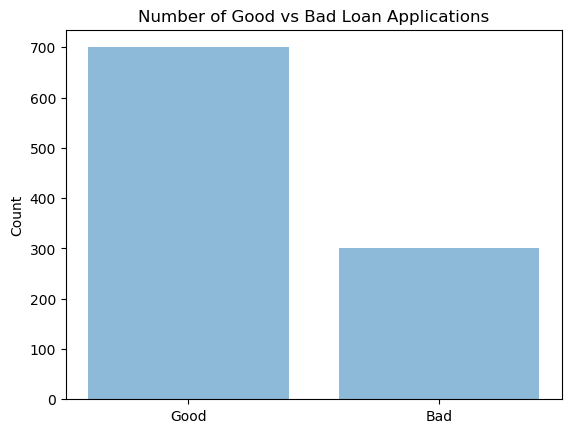

In [28]:
objects = ('Good', 'Bad')
y_pos = np.arange(len(objects))
performance = [700,300]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Number of Good vs Bad Loan Applications')
 
plt.show()

In [29]:
# From the graph above we can see that 300 of our applications were classified as bad/potentially fraudulent. So we will randomly select 300 bad and good transactions.
non_fraud = train[train['class'] == 0]
fraud = train[train['class'] == 1]

In [30]:
# concatenating both into a subsample data set with equal class distribution
non_fraud.reset_index(drop=True, inplace=True)
fraud.reset_index(drop=True, inplace=True)

In [31]:
subsample = pd.concat([non_fraud, fraud])
len(subsample)

912

In [32]:
# Re-shuffling the data set.
subsample = subsample.sample(frac=1).reset_index(drop=True)
subsample.head(10)

,checking_balance,class,credit_history,foreign_worker,gender,housing,job,purpose,savings_balance,scaled_existing_credits,scaled_current_balance,scaled_credit_usage,scaled_age
0,0,1,2,1,1,2,1,3,0,-0.704926,0.199815,1.252574,0.831502
1,0,1,2,1,0,2,2,3,1,-0.704926,-0.609380,0.256953,-0.311879
2,2,1,2,1,1,2,2,0,0,-0.704926,1.848685,2.248194,-1.015499
3,0,1,4,1,0,2,2,1,1,1.027079,0.911182,1.252574,-0.048022
4,0,1,2,1,0,2,1,0,1,-0.704926,1.460924,0.256953,0.655598
5,1,1,2,1,1,2,1,9,1,-0.704926,-0.873794,-0.489762,-1.191404
6,2,1,4,1,0,2,3,1,1,1.027079,-0.500211,-0.738668,-0.135974
7,1,1,2,1,0,0,2,2,1,-0.704926,-0.043334,0.256953,-1.191404
8,0,1,2,0,0,2,1,0,1,-0.704926,-0.611506,-0.904604,-0.399832
9,1,1,4,1,0,2,1,9,1,1.027079,-0.522541,-0.655699,-0.663689


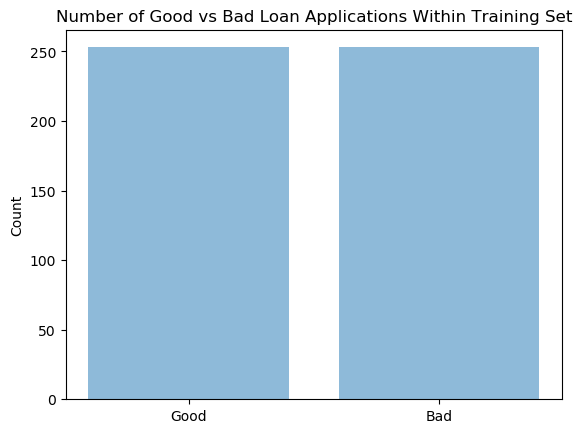

In [72]:
objects = ('Good', 'Bad')
y_pos = np.arange(len(objects))
performance = [253,253]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Number of Good vs Bad Loan Applications Within Training Set')
 
plt.show()

In [34]:
#taking a look at correlation concerning only class once more.
corr = subsample.corr()
corr = corr[['class']]
corr

,class
checking_balance,-0.204537
class,1.000000
credit_history,0.222928
foreign_worker,-0.090039
gender,-0.065819
housing,0.103443
job,-0.034914
purpose,-0.029720
savings_balance,0.032728
scaled_existing_credits,0.049761


### Dimensionality Reduction.

In [35]:
from sklearn.manifold import TSNE

X = subsample.drop('class', axis=1)
y = subsample['class']

In [36]:
# PCA analysis. find PCA and transform to new coordinates
pca_model = PCA()
D_PCA = pca_model.fit_transform(X)

# create a new pandas dataframe 
df_plot = pd.DataFrame(D_PCA, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12'])
df_plot.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,0.274976,0.915270,0.278539,0.738109,-0.783825,-1.318824,-0.140874,-0.766456,-1.344655,0.302086,0.795100,0.000538
1,0.182201,0.136597,-0.653991,-0.261224,-0.163731,-1.241883,-0.119293,-0.400489,-0.286553,-0.472910,-0.311282,-0.031800
2,-2.540774,3.307210,0.586083,-0.749314,-0.913130,0.756702,-0.261324,-0.756165,-0.456331,0.112318,0.776839,-0.002239
3,-1.734383,0.198756,2.395399,-0.857891,0.050721,-0.382785,-0.101177,-0.558118,-0.311014,-0.016841,-0.159439,-0.035937
4,-2.722486,1.224546,0.411130,0.621036,0.162923,-1.162389,0.062034,-0.738124,-0.191577,1.372807,-0.229476,-0.110424


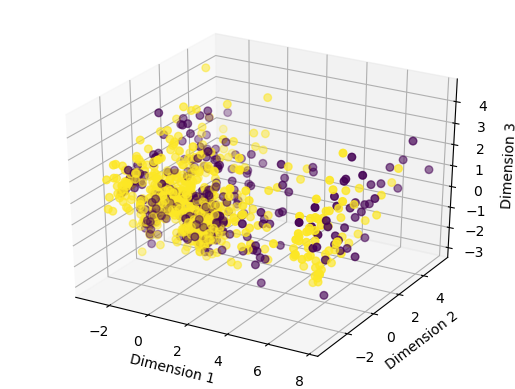

In [37]:
# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(D_PCA[:, 0], D_PCA[:, 1],zs= D_PCA[:, 2], c=y, s=30)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()

[0.48326176 0.11251034 0.1039748  0.06102294 0.05837617 0.05454608
 0.03691718 0.02699883 0.02561074 0.02175456 0.0128941  0.00213251]


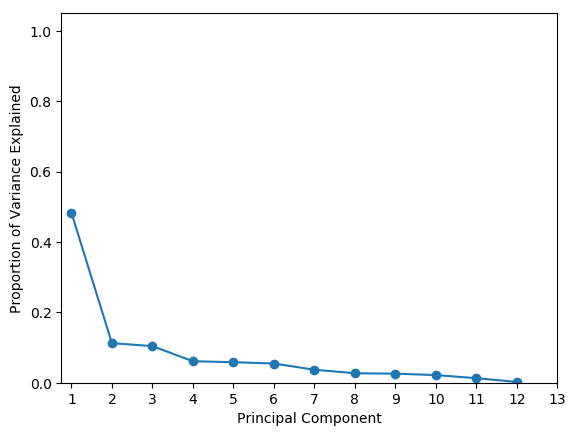

In [38]:
# Variance ratio of the principal components
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

plt.plot([1,2,3,4,5,6,7,8,9,10,11,12], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13])
plt.show()

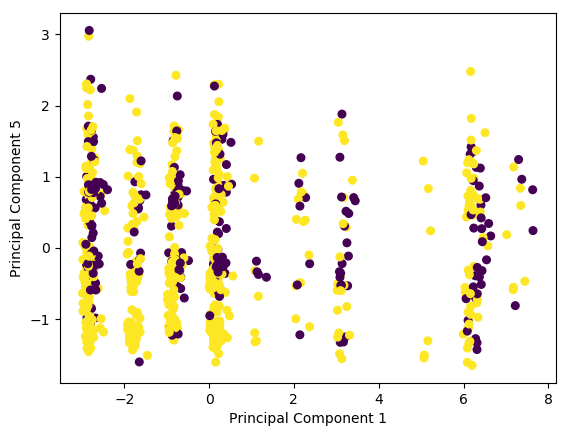

In [39]:
plt.scatter(D_PCA[:, 0], D_PCA[:, 5], c=y, s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 5')
plt.show()

In [40]:
# t-SNE
X_reduced_tsne = TSNE(n_components=3, random_state=42).fit_transform(X.values)

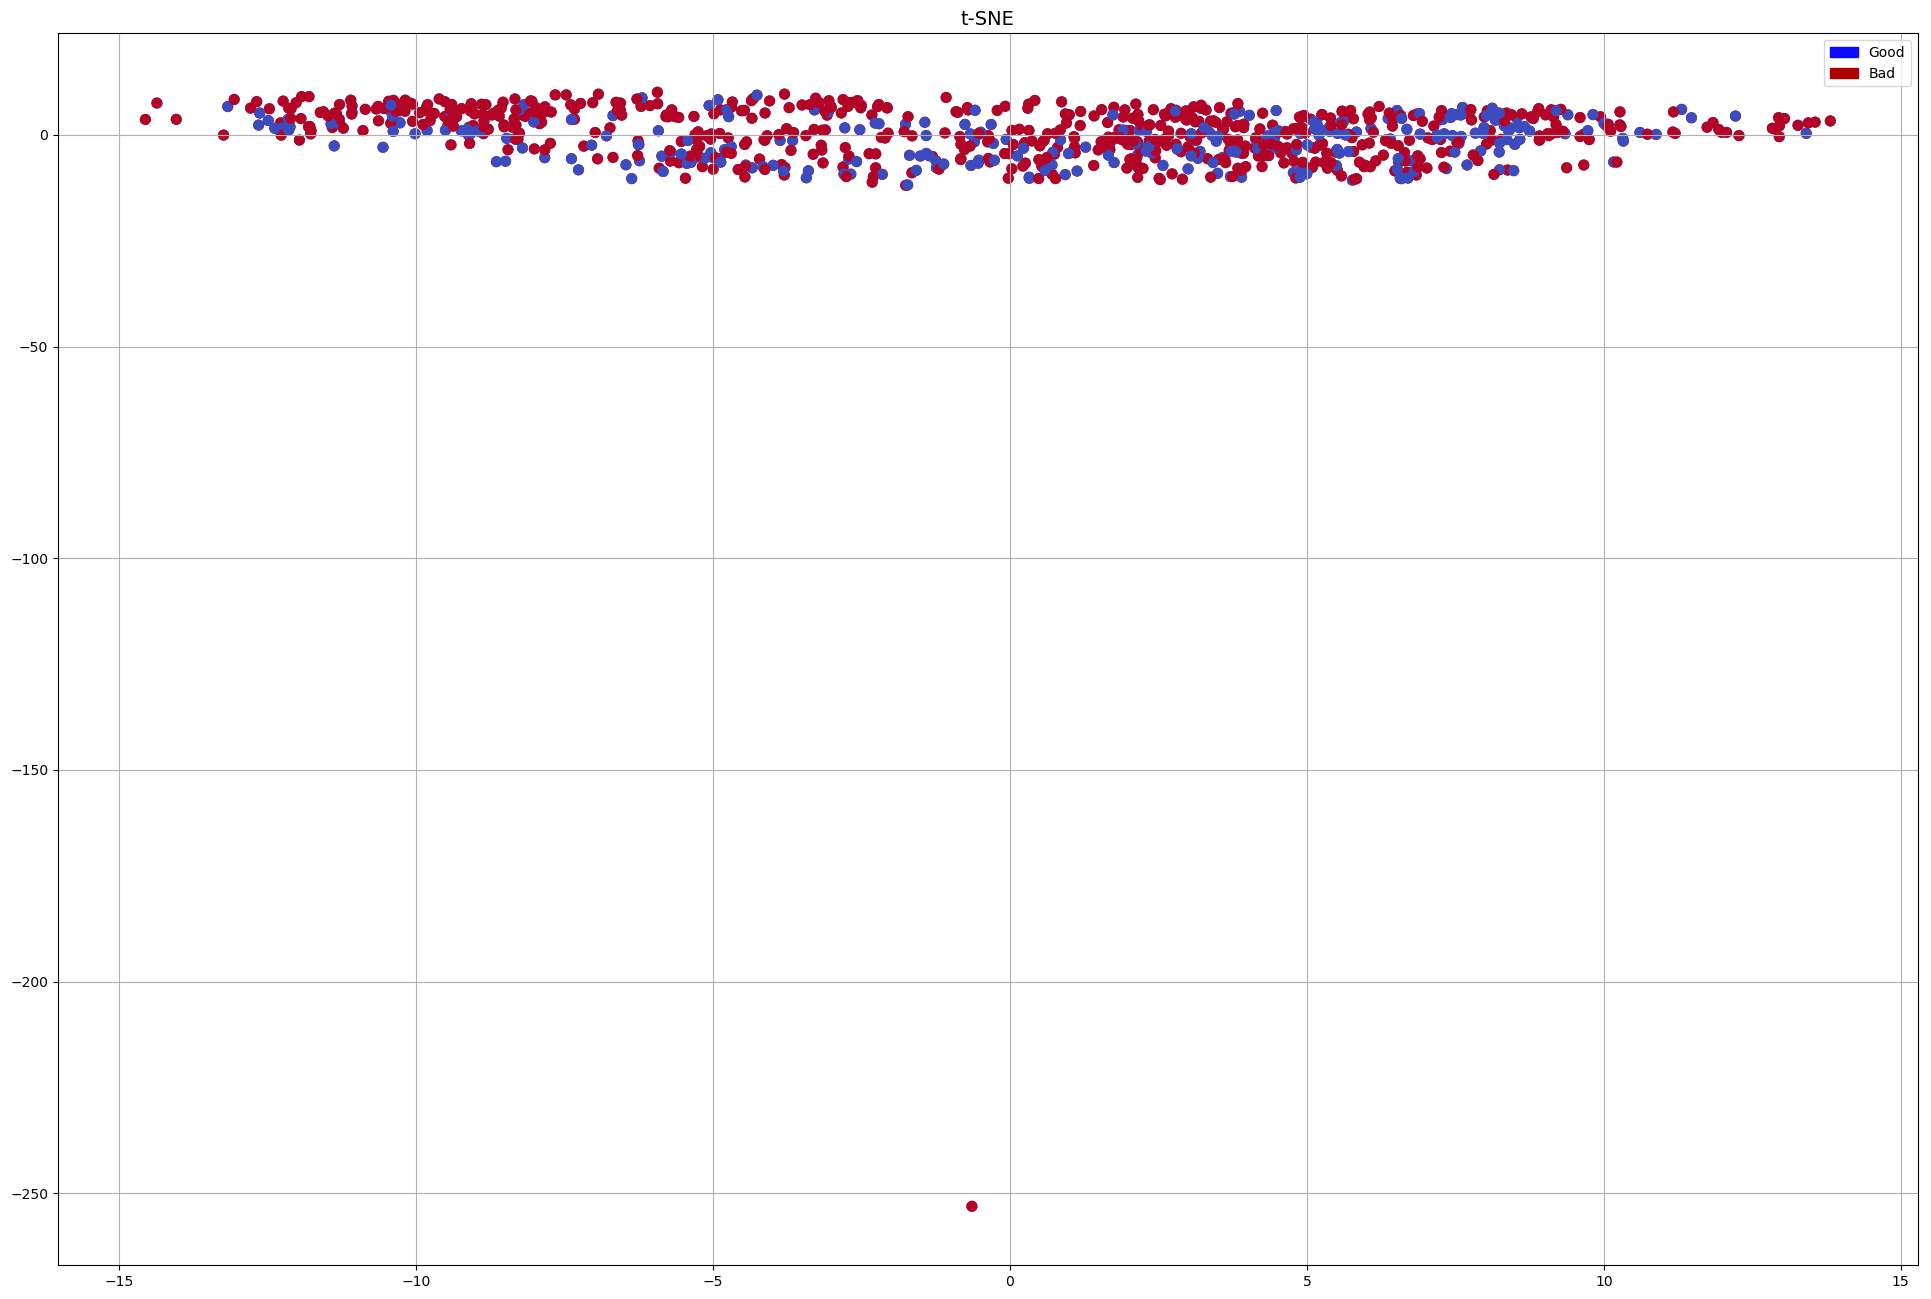

In [41]:
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='Good')
red_patch = mpatches.Patch(color='#AF0000', label='Bad')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Bad', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Good', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

## Single Layer Percepitron Algorithm

This is our baseline algorithm

Since the Perceptron algorithm uses float variable types we will just use certain columns from our dataset.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [44]:
X1 = X[['savings_balance','scaled_existing_credits','scaled_current_balance','scaled_credit_usage','scaled_age']]

In [45]:
# Build a classifier using the training dataset.
perceptron = Perceptron(tol = 1e-3, fit_intercept = True, max_iter = 100)
perceptron.fit(X_train, y_train)


# Compute the accuracy and the confusion matrix of the model using the test dataset. 
y_pred = perceptron.predict(X_test)
print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Accuracy =  0.7431693989071039
Confusion Matrix:
[[ 10  38]
 [  9 126]]


## Multiple Layer Percepitron Algorithm

In [73]:


y = data1['class']
X1 = data1[['savings_balance','scaled_existing_credits','scaled_current_balance','scaled_credit_usage','scaled_age']]
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.7, random_state=42)

X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

# manual train test split using numpy's random.rand
mask = np.random.rand(len(data1)) < 0.9
train = data1[mask]
test = data1[~mask]
print('Train Shape: {}\nTest Shape: {}'.format(train.shape, test.shape))


mlp = MLPClassifier(hidden_layer_sizes=(4,3),max_iter=10000)

mlp.fit(X_train,y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))



Train Shape: (896, 17)
Test Shape: (104, 17)
[[ 47 161]
 [ 72 420]]
              precision    recall  f1-score   support

           0       0.39      0.23      0.29       208
           1       0.72      0.85      0.78       492

   micro avg       0.67      0.67      0.67       700
   macro avg       0.56      0.54      0.54       700
weighted avg       0.63      0.67      0.64       700



### SVM Model

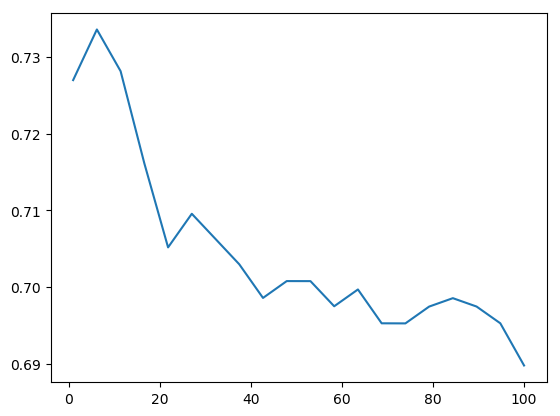

In [46]:
# Finding the best value of C by using cross_val_score and plotting the results.
Cs = np.linspace(1,100,20)
Accuracies = np.zeros(Cs.shape[0])

for i,C in enumerate(Cs):
    C_test = svm.SVC(kernel='rbf', C = C, gamma = 'scale')
    scores = cross_val_score(estimator = C_test, X = X, y = y, cv=5, scoring='accuracy')
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()

From this plot, we can tell the value of C which results in the highest accuracy is ~5. 

In [47]:
# Build a classifier using the training dataset.
SVM_model = svm.SVC(kernel='rbf', C = 4, gamma = 'scale')
SVM_model.fit(X_train, y_train)


# Compute the accuracy and the confusion matrix of the model using the test dataset. 
y_pred = SVM_model.predict(X_test)
print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Accuracy =  0.7486338797814208
Confusion Matrix:
[[ 20  28]
 [ 18 117]]


### Decision Tree

In [48]:
decisionTree = tree.DecisionTreeClassifier(max_depth = 4)

# fit the tree with the traing data
decisionTree = decisionTree.fit(X_train, y_train)

# predict with the training data
y_pred_train = decisionTree.predict(X_train)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(X_test)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data =  0.7626886145404664
Accuracy on test data =  0.7595628415300546


When training and testing using all of our data we get a 100% accuracy on the training data set which is expected since this would overfit the data. But, we still recieve a faily low accuracy on our test set.

Let's work only with the numerical and categorical variables and omit values could contain information that is hard to make sense of without more context.

In [49]:
A = subsample[['scaled_age', 'credit_history', 'scaled_credit_usage', 'scaled_current_balance', 'scaled_existing_credits']]
decisionTree = tree.DecisionTreeClassifier(max_depth = 3)

ATrain, ATest, yTrain, yTest = train_test_split(A,y)
# fit the tree with the traing data
decisionTree = decisionTree.fit(ATrain, yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(ATrain)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(ATest)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data =  0.7470760233918129
Accuracy on test data =  0.7324561403508771


What we can take away from this Decision Tree is that if we focus our analysis on factors that are mainly concerned with the applicants credit, then we can get a fairly accurate prediction on whether an applicant would be approved for a loan or not at an accuracy of 70%.

### Random Forest

In [50]:
forest =  RandomForestClassifier(bootstrap=True, n_estimators=1000, random_state=0)

trained_forest = forest.fit(X_train, y_train)

y_pred_train = trained_forest.predict(X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))

y_pred = trained_forest.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

Accuracy on training data=  1.0
Accuracy on test data=  0.7650273224043715


In [51]:
# concatenating newly created columns with original data
data1 = pd.concat([data, scaled_ec.rename('scaled_existing_credits'), scaled_cb.rename('scaled_current_balance'), scaled_cu.rename('scaled_credit_usage') ,scaled_age.rename('scaled_age')], axis=1)
data1.head()

print(len(X1),
len(X_train),
len(X_validation),
len(y_train),
len(y_validation))

912 729 183 729 183
